<a href="https://colab.research.google.com/github/ritikjain00/Forest-Fire-Dectection/blob/master/Forest_fires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
file = files.upload()

Saving forestfires.csv to forestfires.csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(file['forestfires.csv']))

In [4]:
print(data.shape)

(517, 13)


In [5]:
print(data.head(5))

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


In [6]:
print(data.columns)

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')


In [7]:
print(data.dtypes)

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object


In [8]:
data.describe(include='all')

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517,517,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
unique,NaN,NaN,12,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,aug,sun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,184,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.669246,4.299807,NaN,NaN,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,NaN,NaN,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,NaN,NaN,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,NaN,NaN,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,NaN,NaN,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,NaN,NaN,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000


As counts of each columns is same, we could say that there are no missing values in any columns.But to be sure we must check it again.


We can see 50% of the data i.e. median of the data have higher mean value than median.So we can infer that data is right skewed(clustered at lower values).




So we will perform transformation operation to remove skewness of the data.


In [9]:
#checking if any missing values for confirmation
print(data.isnull().sum())

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


In [10]:
target = 'area'

In [11]:
data_new = data.drop(columns=target)

In [12]:
#separating data into numerical and categorical columns
cate_data = data_new.select_dtypes(include='object').columns.tolist()
num_data = data_new.select_dtypes(exclude='object').columns.tolist()
print('Categorical Data: ',cate_data)
print('Numerical Data: ',num_data)

Categorical Data:  ['month', 'day']
Numerical Data:  ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


Skewness refers to distortion or asymmetry in a symmetrical bell curve, or normal distribution, in a set of data. If the curve is shifted to the left or to the right, it is said to be skewed.

The mean of positively skewed data will be greater than the median.
In a distribution that is negatively skewed, the exact opposite is the case: the mean of negatively skewed data will be less than the median. 

If a data graph is symmetrical,the distribution has zero skewness.

In [13]:
#Checking the skewness and Kurtosis of data_new
print("Skew:\n{}".format(data_new.skew()))

Skew:
X        0.036246
Y        0.417296
FFMC    -6.575606
DMC      0.547498
DC      -1.100445
ISI      2.536325
temp    -0.331172
RH       0.862904
wind     0.571001
rain    19.816344
dtype: float64


Kurtosis is a statistical measure that is used to describe the distribution.
Kurtosis measures extreme values in either tail.
Distributions with large kurtosis exhibit tail data exceeding the tails of the normal distribution . 
Distributions with low kurtosis exhibit tail data that are generally less extreme than the tails of the normal distribution. 

PS:Kurtosis should not be confused with peakness.Kurtosis defines shape of tail.

In [14]:
print("Kurtosis:\n{}".format(data_new.kurtosis()))

Kurtosis:
X        -1.172331
Y         1.420553
FFMC     67.066041
DMC       0.204822
DC       -0.245244
ISI      21.458037
temp      0.136166
RH        0.438183
wind      0.054324
rain    421.295964
dtype: float64


Distribution with skewness greater than +1 and -1 are highly skewed


1.   'rain' and 'ISI have positive skewness so they are right skewed.
2.   'FFMC' and 'DC' have negative skewness so they are left skewed.







Distribution with Kurtosis greater than +3 and -3 have higher kurtosis value which signifies there are outlier in the data.

1. 'FFMC' , 'ISI' , 'rain' have high kurtosis value.


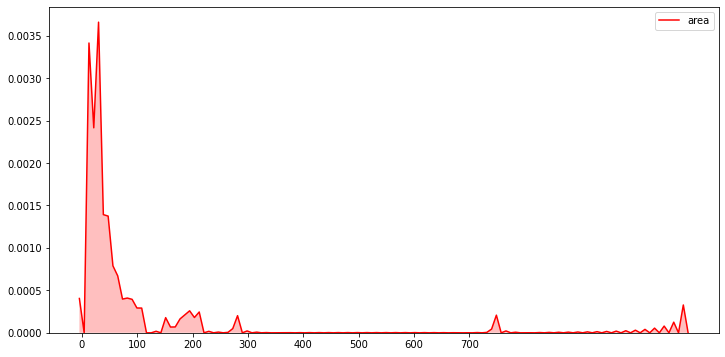

In [15]:
#Graphical representation of skewness
#For Target feature 'area'
plt.figure(figsize=(12,6))
area_plot = sns.kdeplot(data[target],shade=True,color='r')
plt.xticks([i for i in range(0,800,100)])
plt.show()

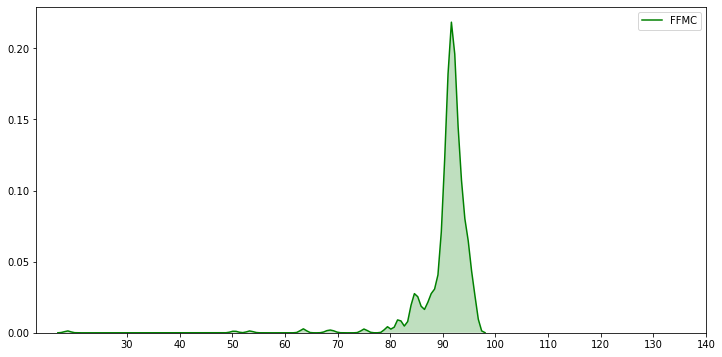

In [16]:
#For FFMC
plt.figure(figsize=(12,6))
ffmc_plot = sns.kdeplot(data['FFMC'],shade=True,color='g')
plt.xticks([i for i in range(30,150,10)])
plt.show()

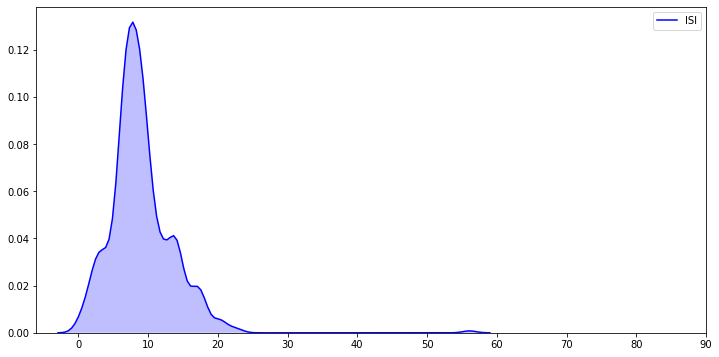

In [17]:
#For ISI
plt.figure(figsize=(12,6))
isi_plot = sns.kdeplot(data['ISI'],shade=True,color='b')
plt.xticks([i for i in range(0,100,10)])
plt.show()

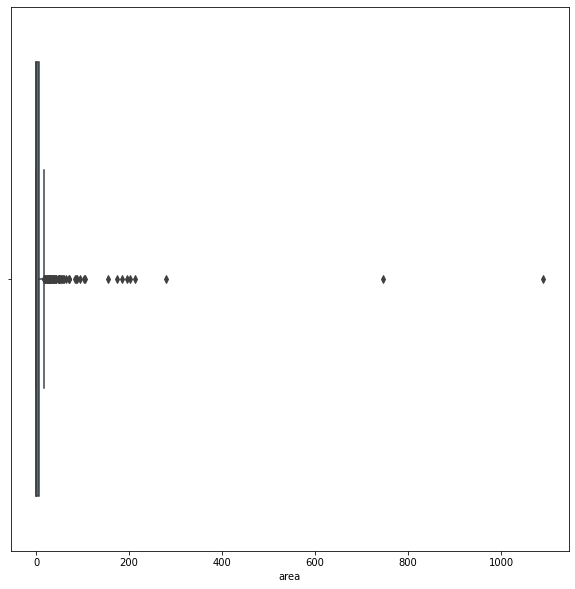

In [18]:

#Checking outlier for target feature
plt.figure(figsize=(10,10))
outlier_target = sns.boxplot(data[target])

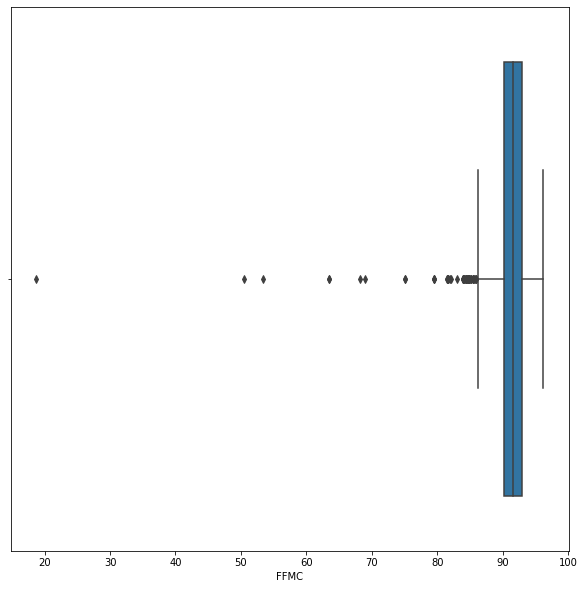

In [19]:
#Checking outlier of FFMC feature
plt.figure(figsize=(10,10))
outlier_ffmc = sns.boxplot(data['FFMC'])

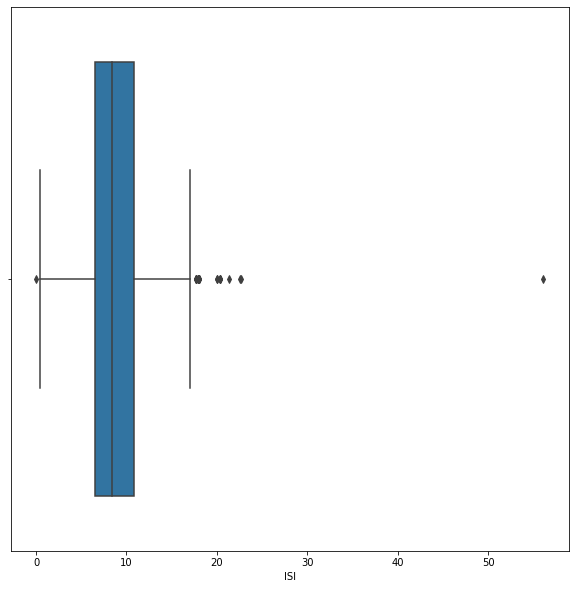

In [20]:
#Checking outlier of ISI feature
plt.figure(figsize=(10,10))
outlier_isi = sns.boxplot(data['ISI'])

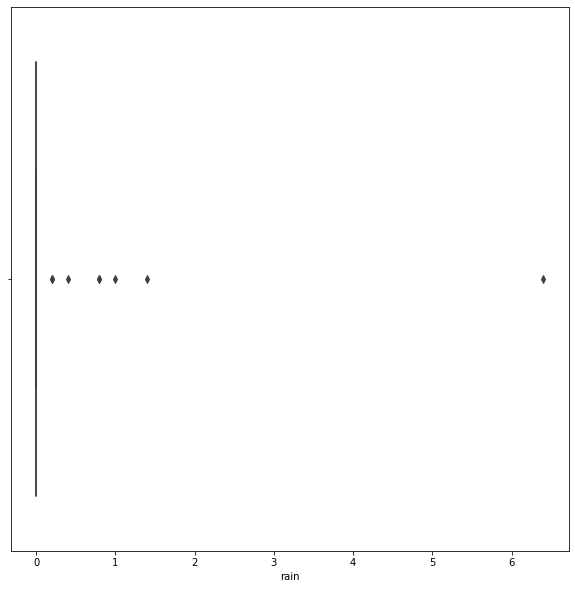

In [21]:
#checking outlier of rain feature
plt.figure(figsize=(10,10))
outlier_rain = sns.boxplot(data['rain'])

We can do two operations on outliers:

1. **Removing:**Removing outliers is legitimate only for specific reasons. Outliers can be very informative about the subject-area and data collection process

2. **Transformation:** A different approach to outliers could be to try creating a transformation of the data rather than using the data itself.

First we will try to transform the data.

In [22]:
out_col = ['area','FFMC','ISI','rain']

In [23]:
np.log1p(data[out_col]).skew()

area     1.217838
FFMC   -11.675394
ISI     -0.937218
rain    14.173028
dtype: float64

In [24]:
np.log1p(data[out_col]).kurtosis()

area      0.945668
FFMC    185.482383
ISI       2.584588
rain    234.240025
dtype: float64

Transforming the data brings no change.We still have high skewness and kurtosis.

Now removing the outliers by z-score method.

In [25]:
remov = data.loc[:,['FFMC']].apply(zscore).abs() < 3

In [26]:
data = data[remov.values]
data.shape

(510, 13)

In [27]:
print(data['rain'].value_counts())

0.0    502
0.8      2
0.2      2
0.4      1
6.4      1
1.4      1
1.0      1
Name: rain, dtype: int64


In [28]:
#Since almost all the values in 'rain' features is zero.so we convert the rain column into categorical column
data['rain'] = data['rain'].apply(lambda x: int(x > 0.0))

In [29]:
out_col.remove('rain')
data[out_col] = np.log1p(data[out_col])

In [30]:
data[out_col].skew() 

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [31]:
data[out_col].kurtosis() 

area    0.923414
FFMC    4.866747
ISI     1.122574
dtype: float64

In [32]:
dummy_data = data.copy()

In [33]:
#label encoding the categorical column
le = LabelEncoder()
dummy_data['day'] = le.fit_transform(dummy_data['day'])
dummy_data['month'] = le.fit_transform(dummy_data['month'])

In [34]:
X = dummy_data.drop(columns = 'area')
y = dummy_data['area']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)

In [36]:
xgb_model = xgb.XGBRegressor(base_score=0.3, booster='gbtree', colsample_bylevel=1,colsample_bytree=0.24, gamma=0,
                             learning_rate=0.01, max_delta_step=0,
                             max_depth=3, min_child_weight=1, missing=None, n_estimators=102,
                             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1)

In [37]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_metric=["rmse"],eval_set=eval_set, verbose=False)
pred = xgb_model.predict(X_test)

In [41]:
def calc_ISE(X_train, y_train, model):
    '''returns the in-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_train, y_train), rmse
    
def calc_OSE(X_test, y_test, model):
    '''returns the out-of-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_test, y_test), rmse

In [42]:
is_r2, ise = calc_ISE(X_train, y_train,xgb_model )
os_r2, ose = calc_OSE(X_test, y_test, xgb_model)

# show dataset sizes
data_list = (('R^2_in', is_r2), ('R^2_out', os_r2), 
             ('ISE', ise), ('OSE', ose))
for item in data_list:
    print('{:10}: {}'.format(item[0], item[1]))

R^2_in    : 0.043406335878035884
R^2_out   : -0.06570278886666991
ISE       : 1.3749029223616027
OSE       : 1.4294759497017118




It is clear that OSE(test error) is near to ISE(training error) which implies our model is ok.

In [45]:
print('train/test: ',ose/ise)

train/test:  1.0396922767800738


In [46]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: %f" % (rmse))

RMSE: 1.429476


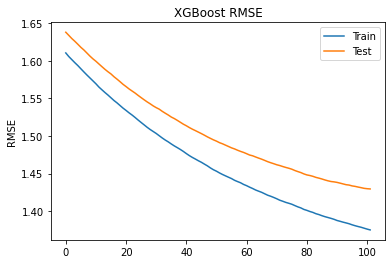

In [47]:
# retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot RMSE
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [48]:
xgb_model.save_model('0001.model_forest_fire')

In [ ]:
'''
#pickle
import pickle

pickle.dump(xgb_model,open('forest_fires_detection.pickle','wb'))

#load model
forest_fires_detection_model = pickle.load(open('forest_fires_detection.pickle','rb'))

#predict the output
yf_pred = forest_fires_detection_model.predict(X_test)
'''